# EnKF using 2D heat equation

**Note about coordinate system**

Matplotlib's `pcolormesh` follows the standard matrix convention: "An array C with shape (nrows, ncolumns) is plotted with the column number as X and the row number as Y."

This means that to get values at the point `(k, x, y)` of a field `u`, we must do `u[k, y, x]`.

In [1]:
%load_ext autoreload

In [2]:
import numpy as np

np.set_printoptions(suppress=True)
rng = np.random.default_rng()

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 12})
from ipywidgets import interact
import ipywidgets as widgets

from p_tqdm import p_map

In [3]:
%autoreload 2
from dass import pde, utils, analysis, taper

# EnKF

Constant parameter, unknown field.
Stop forward model at every point in time where we have observations.

## Define parameters, set true initial conditions and calculate the true temperature field

In [4]:
N = 100

k_start = 0
k_end = 300

# Number of grid-cells in x and y direction
nx = 20

alpha = np.ones((nx, nx)) * 5.0
# alpha[:, nx // 2 :] = 100.0

dx = 1
dt = dx**2 / (4 * np.max(alpha))  # Max dt
# Amount of noise in the heat equation is dependent on the value of `dt`.
# Making this smaller adds less noise which yields less change from one step to the other.
# dt = dt / 10.0

# True initial temperature field.
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0
u = np.empty((k_end, nx, nx))
u.fill(0.0)
# Set the boundary conditions
u[:, (nx - 1) :, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (nx - 1) :] = u_right

u = pde.heat_equation(u, alpha, dx, dt, k_start, k_end, rng=rng, scale=None)

## Interactive plot of true temperature field

In [5]:
def interactive_truth(k):
    fig, ax = plt.subplots()
    fig.suptitle("True temperature field")
    p = ax.pcolormesh(u[k], vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()
    
interact(
    interactive_truth,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=299), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_truth(k)>

## Define random seeds because multiprocessing

https://numpy.org/doc/stable/reference/random/parallel.html#seedsequence-spawning

In [6]:
ss = np.random.SeedSequence(12345)
child_seeds = ss.spawn(N)
streams = [np.random.default_rng(s) for s in child_seeds]

## Generate truth and observations based on truth

In [7]:
u = pde.heat_equation(
    u, alpha, dx, dt, k_start, k_end, np.random.default_rng(12345), np.sqrt(dt)
)

# placement of sensors, i.e, where the observations are done
#padding = int(0.15 * nx)
#x = np.linspace(padding, nx - padding, 3, dtype=int)
#y = np.linspace(padding, nx - padding, 3, dtype=int)
#obs_coordinates = [utils.Coordinate(xc, yc) for xc in x for yc in y]

obs_coordinates = [utils.Coordinate(nx // 2, nx - 2)]

# At which times observations are taken
obs_times = np.linspace(5, k_end, 50, endpoint=False, dtype=int)

d = utils.observations(obs_coordinates, obs_times, u)
# number of measurements
m = d.shape[0]
print("Number of observations: ", m)

Number of observations:  50


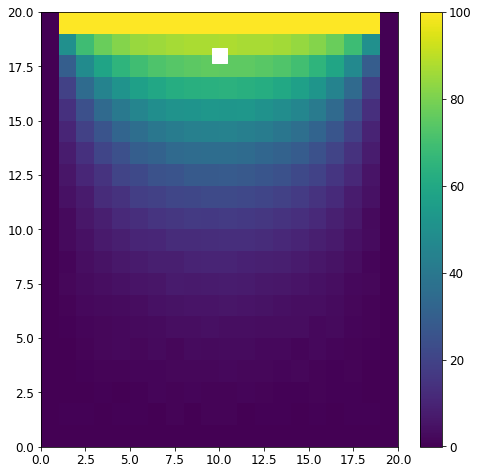

In [120]:
# Plot temperature field and show placement of sensors.
obs_xy = set(zip(d.index.get_level_values("x"), d.index.get_level_values("y")))
x, y = zip(*obs_xy)

fig, ax = plt.subplots()
p = ax.pcolormesh(u[100], cmap=plt.cm.viridis)
fig.colorbar(p)
ax.plot(x, y, "s", color="white", markersize=15)

In [65]:
def gen_field():
    u = np.empty((k_end, nx, nx))
    u.fill(0.0)

    # Set the boundary conditions
    #u[:, (nx - 1) :, :] = (u_top / 2) + rng.normal(0, 20, nx)
    u[:, (nx - 1) :, :] = (u_top / 2) + rng.normal(0, 20)
    u[:, :, :1] = u_left
    u[:, :1, 1:] = u_bottom
    u[:, :, (nx - 1) :] = u_right

    return u


fields = [gen_field() for _ in range(N)]

In [66]:
def matrix_from_fields(fields, k):
    nx = fields[0][0].shape[0]
    A = np.zeros(shape=(nx * nx, N))
    for f in range(len(fields)):
        A[:, f] = fields[f][k].ravel()
    return A

In [67]:
d.index.get_level_values("k").unique()

Int64Index([  5,  10,  16,  22,  28,  34,  40,  46,  52,  58,  64,  69,  75,
             81,  87,  93,  99, 105, 111, 117, 123, 128, 134, 140, 146, 152,
            158, 164, 170, 176, 182, 187, 193, 199, 205, 211, 217, 223, 229,
            235, 241, 246, 252, 258, 264, 270, 276, 282, 288, 294],
           dtype='int64', name='k')

## Plot tapering function used for localisation

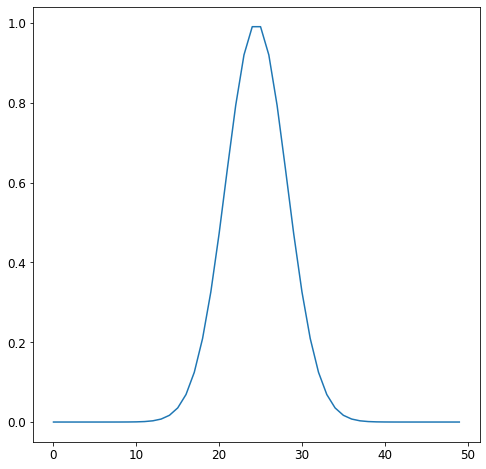

In [103]:
fig, ax = plt.subplots()
ax.plot(taper.gauss(np.linspace(-nx, nx), 3.0))

In [79]:
A_no_update = {}
localize = True
k_start = 0
for k_obs in d.index.get_level_values("k").unique().to_list():
    fields = p_map(
        pde.heat_equation,
        fields,
        [alpha] * N,
        [dx] * N,
        [dt] * N,
        [k_start] * N,
        [k_obs + 1] * N,
        streams,
        [np.sqrt(dt)] * N,
        desc=f"Running forward model from {k_start} to {k_obs}",
    )

    d_k = d.query(f"k == {k_obs}")
    m = d_k.shape[0]

    A = matrix_from_fields(fields, k_obs)
    A_no_update[k_obs] = A.copy()
    
    # measure response
    Y = np.zeros(shape=(m, N))
    for i in range(N):
        # It's A[y, x] and not A[x, y] due to convention followed by matplotlib's pcolormesh.
        Y[:, i] = A[:, i].reshape(nx, nx)[
            d_k.index.get_level_values("y").to_list(),
            d_k.index.get_level_values("x").to_list(),
        ]

    Cdd = np.diag(d_k.sd.values**2)

    E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
    E = E - E.mean(axis=1, keepdims=True)
    assert E.shape == (m, N)

    D = np.ones((m, N)) * d_k.value.values.reshape(-1, 1) + E

    S = Y - Y.mean(axis=1, keepdims=True)

    A_centered = A - A.mean(axis=0, keepdims=True)
    Dprime = D - Y

    if localize:
        for i in range(nx**2):
            state_idx = np.unravel_index(i, shape=(nx, nx))
            dist = np.sqrt((state_idx[0] - obs_coordinates[0].y)**2 + (state_idx[1] - obs_coordinates[0].x)**2)
            taper_coeff = taper.gauss(dist, 2.0)
            
            K = (
                A_centered[i, :]
                @ S.T
                @ np.linalg.pinv(S @ S.T + (N - 1) * Cdd)
            )
        
            #K = (
            #    A_centered[i, :]
            #    @ S.T
            #    @ np.linalg.pinv(S @ S.T + (N - 1) * (1 / taper_coeff**2) * Cdd)
            #)
            
            A[i, :] = A[i, :] + np.sqrt(taper_coeff) * K @ (Dprime)
    else:
        K = A_centered @ S.T @ np.linalg.pinv(S @ S.T + (N - 1) * Cdd)
        A = A + K @ Dprime

    for i in range(N):
        fields[i][k_obs:] = A[:, i].reshape(nx, nx)

    k_start = k_obs

Running forward model from 0 to 5:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 5 to 10:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 10 to 16:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 16 to 22:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 22 to 28:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 28 to 34:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 34 to 40:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 40 to 46:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 46 to 52:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 52 to 58:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 58 to 64:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 64 to 69:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 69 to 75:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 75 to 81:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 81 to 87:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 87 to 93:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 93 to 99:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 99 to 105:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 105 to 111:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 111 to 117:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 117 to 123:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 123 to 128:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 128 to 134:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 134 to 140:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 140 to 146:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 146 to 152:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 152 to 158:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 158 to 164:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 164 to 170:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 170 to 176:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 176 to 182:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 182 to 187:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 187 to 193:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 193 to 199:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 199 to 205:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 205 to 211:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 211 to 217:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 217 to 223:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 223 to 229:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 229 to 235:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 235 to 241:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 241 to 246:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 246 to 252:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 252 to 258:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 258 to 264:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 264 to 270:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 270 to 276:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 276 to 282:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 282 to 288:   0%|          | 0/100 [00:00<?, ?it/s]

Running forward model from 288 to 294:   0%|          | 0/100 [00:00<?, ?it/s]

## Plot difference between prior and posterior of a single update

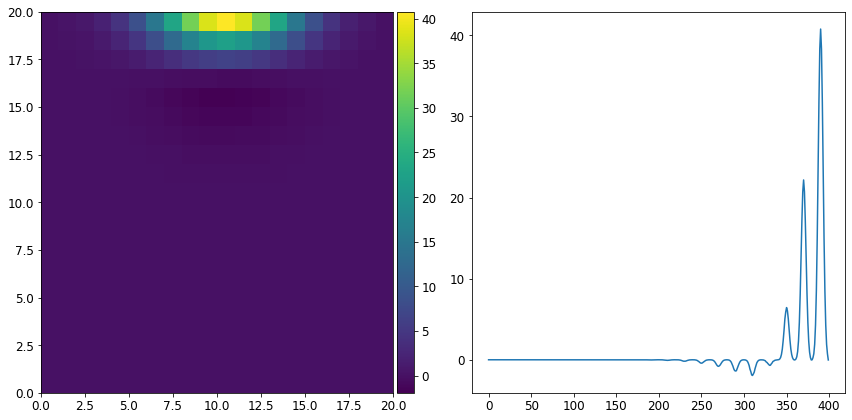

In [118]:
k_obs = 5
prior_mean_field = A_no_update[k_obs].mean(axis=1).reshape(nx, nx)
posterior_mean_field = matrix_from_fields(fields, k_obs).mean(axis=1).reshape(nx, nx)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
p1 = axes[0].pcolormesh(posterior_mean_field - prior_mean_field)
utils.colorbar(p1)

axes[1].plot(posterior_mean_field.ravel() - prior_mean_field.ravel())

fig.tight_layout()

## Interactive plotting

In [100]:
def updated_vs_truth(k):
    vmin = 0
    vmax = 100
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(f"k = {k}")

    A_with_update = matrix_from_fields(fields, k)

    axes[0].set_title("With update")
    p0 = axes[0].pcolormesh(
        A_with_update.mean(axis=1).reshape(nx, nx),
        cmap=plt.cm.viridis,
        vmin=vmin,
        vmax=vmax,
    )

    axes[1].set_title("Truth")
    p1 = axes[1].pcolormesh(u[k], cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)

    
    utils.colorbar(p1)
    
    fig.tight_layout()
    
interact(
    updated_vs_truth,
    k=widgets.IntSlider(min=0, max=d.index.get_level_values("k").max(), step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=294), Output()), _dom_classes=('widget-interact'…

<function __main__.updated_vs_truth(k)>